# Practical n°3: Pixel-scale Prediction - Weakly Supervised Case

## Part II: denoising with FCN - weakly-supervised approaches




In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch.optim as optim
from PIL import Image

First, import the functions contained in the "utile" module.

In [2]:
! git clone https://github.com/relmonta/ml-student.git

Cloning into 'ml-student'...
remote: Enumerating objects: 413, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 413 (delta 131), reused 149 (delta 95), pack-reused 210
Receiving objects: 100% (413/413), 77.91 MiB | 10.98 MiB/s, done.
Resolving deltas: 100% (171/171), done.
Updating files: 100% (81/81), done.


In [3]:
! ls

ml-student  sample_data


In [4]:
os.chdir('ml-student/TP3')

In [5]:
os.listdir('.')
from utile import *

###Exercise 1: The "noise to noise" scenario

In Exercise 2, Part I, we had pairs (noisy version, clean version) to learn from. However, in real-world applications, clean versions are barely available. \
Sometimes, there are instances where multiple noisy versions are accessible. Consider, for example, photos taken with a telephoto lens with several seconds between shots: the effects of air turbulence on image quality are independent from one image to another. \
In the "noise to noise" scenario [(Lehtinen,2018)](https://arxiv.org/pdf/1803.04189.pdf), we have pairs of independently noisy images, organized into two sets $B^1_{noisy}$ and $B^2_{noisy}$.
To situate ourselves in this scenario, we utilize the synthetic images from Exercise 1. The gen_noise2noise function allows us to sample from both datasets:

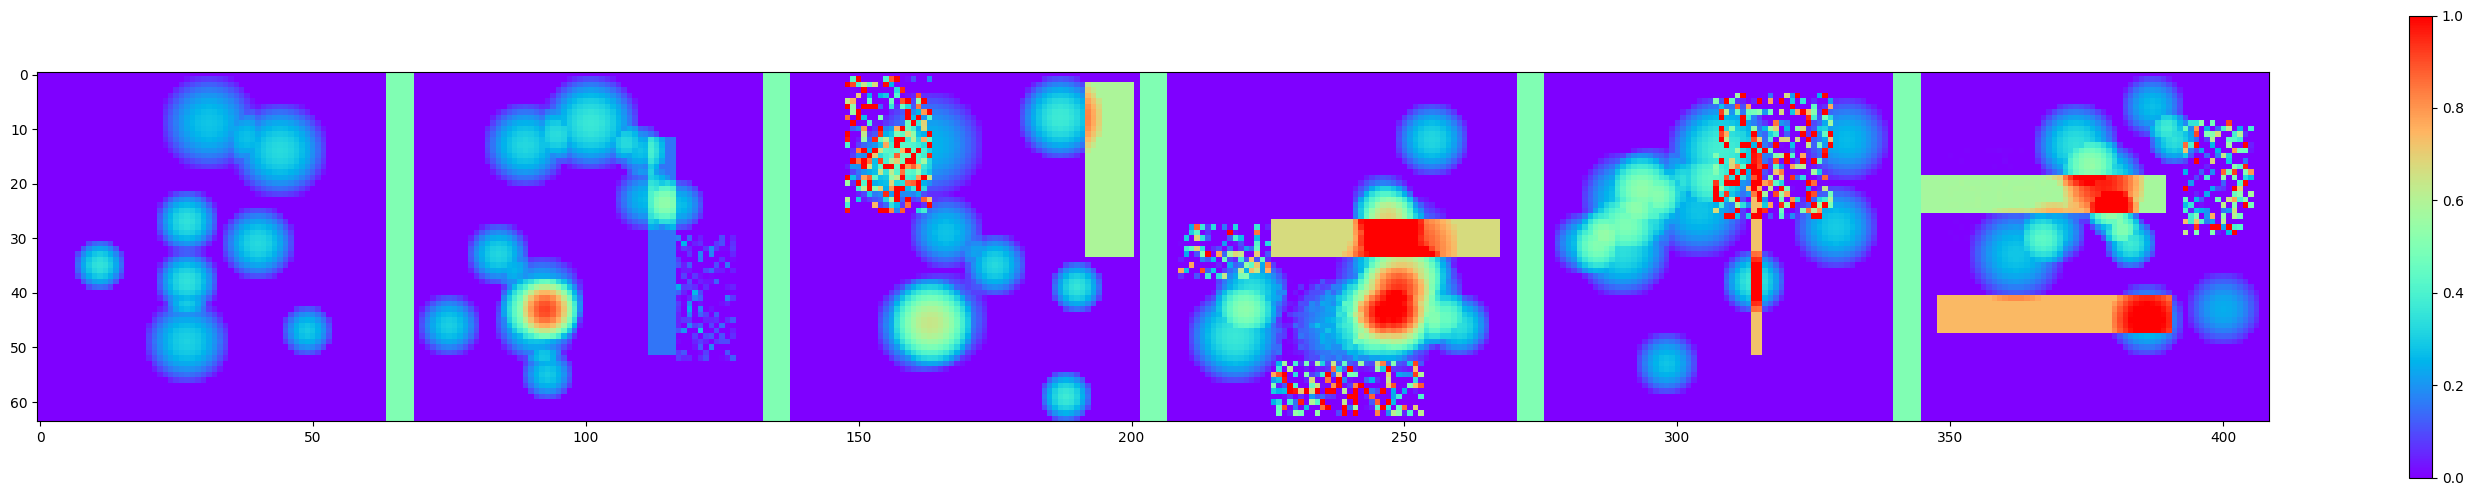

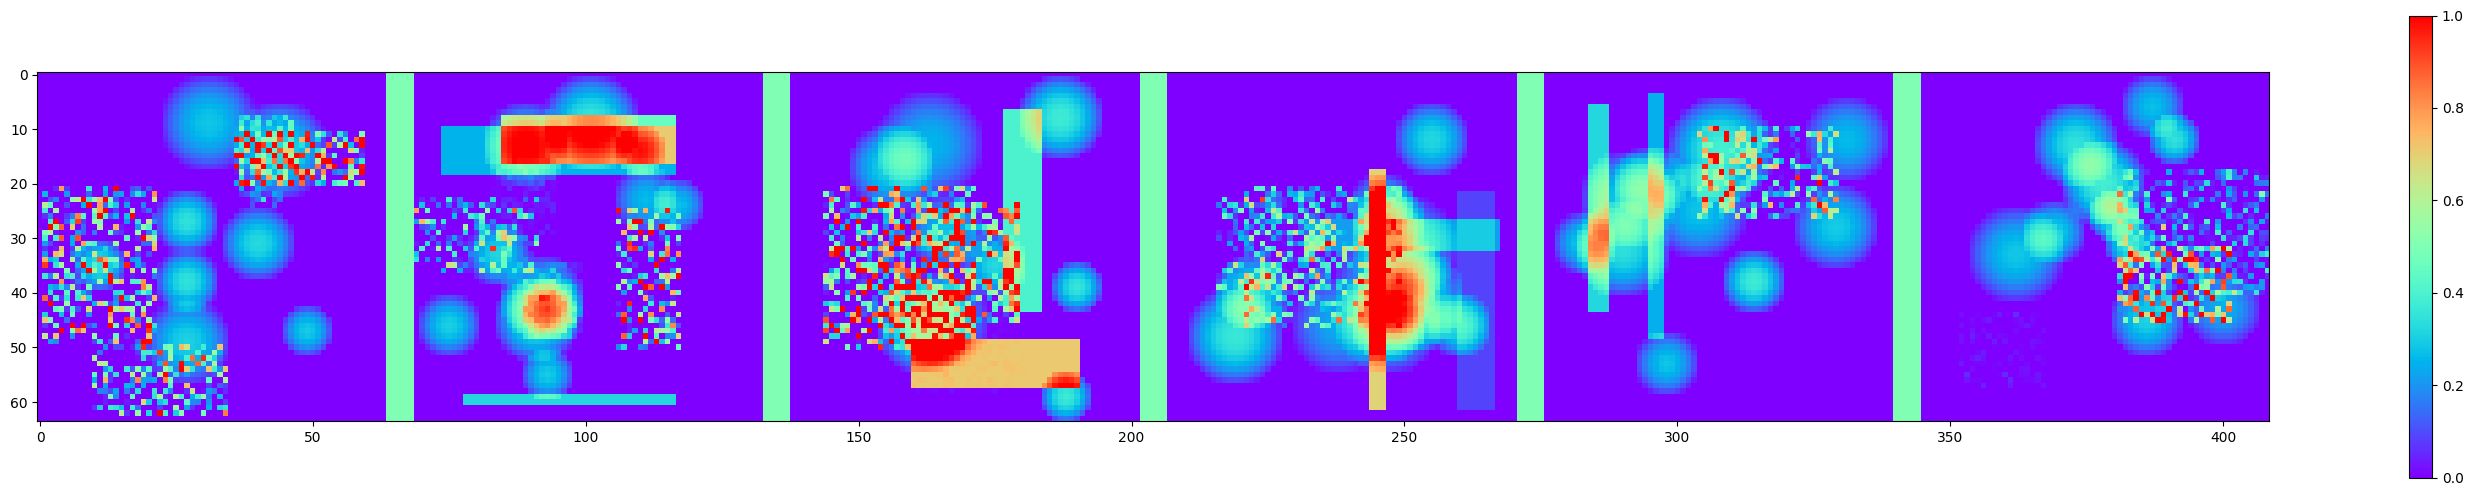

In [6]:
image1, image2 = gen_noise2noise(6)
fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(image1, 6, fig, k=0, min_scale=0,max_scale=1)

fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(image2.detach().cpu(), 6, fig2, k=0, min_scale=0,max_scale=1)

**Q1** Define a learning procedure that effectively denoises the image.

In [7]:
fcn = UNet(1,1,16).cuda()

import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-3))

In [8]:
nepochs = 40
nbatches = 100
batchsize = 64

train_losses = []


def criterion(output,target):
  return torch.mean(torch.abs(output-target))  # idea: use the MAE loss to target the conditionnal median

for epoch in range(nepochs):


    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):
        #Load inputs

        # Generation
        input,target = gen_noise2noise(batchsize)

        # go to GPU
        input = input.cuda()
        target = target.cuda()

        # zeroing gradients, forward pass
        optimizer.zero_grad()
        output = fcn(input)

        # loss and compuation of gradients
        loss = criterion(output,target)
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)
    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

0.10645728
Epoch 1
epoch loss : 

0.08538452
Epoch 2
epoch loss : 

0.08422102
Epoch 3
epoch loss : 

0.08249641
Epoch 4
epoch loss : 

0.08276426
Epoch 5
epoch loss : 

0.08198558
Epoch 6
epoch loss : 

0.0812426
Epoch 7
epoch loss : 

0.080446176
Epoch 8
epoch loss : 

0.079579964
Epoch 9
epoch loss : 

0.08040278
Epoch 10
epoch loss : 

0.080219574
Epoch 11
epoch loss : 

0.08037107
Epoch 12
epoch loss : 

0.07959123
Epoch 13
epoch loss : 

0.07949128
Epoch 14
epoch loss : 

0.079146
Epoch 15
epoch loss : 

0.080014795
Epoch 16
epoch loss : 

0.07986264
Epoch 17
epoch loss : 

0.079141736
Epoch 18
epoch loss : 

0.07850854
Epoch 19
epoch loss : 

0.07895625
Epoch 20
epoch loss : 

0.07831775
Epoch 21
epoch loss : 

0.07825413
Epoch 22
epoch loss : 

0.07859799
Epoch 23
epoch loss : 

0.07828296
Epoch 24
epoch loss : 

0.077603355
Epoch 25
epoch loss : 

0.07756747
Epoch 26
epoch loss : 

0.078385696
Epoch 27
epoch loss : 

0.078754485
Epoch 28
epoch loss : 

0

Différentes loss à utiliser pour différents cas :
Classification binaire : CrossEntropyLoss
Classsification multi-variée : CrossEntropyLoss
Régression : MSE, MAE
NLP : CrossEntropyLoss
Siamese Networks : TripletMargin Loss
Auto-encodeurs : MSE
GAN : Binary CrossEntropyLoss pour le discriminateur, MSE ou Binary CrossentropyLoss pour le générateur

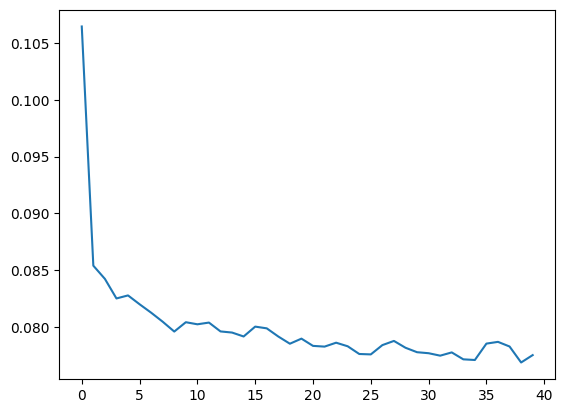

In [9]:
plt.plot(train_losses)

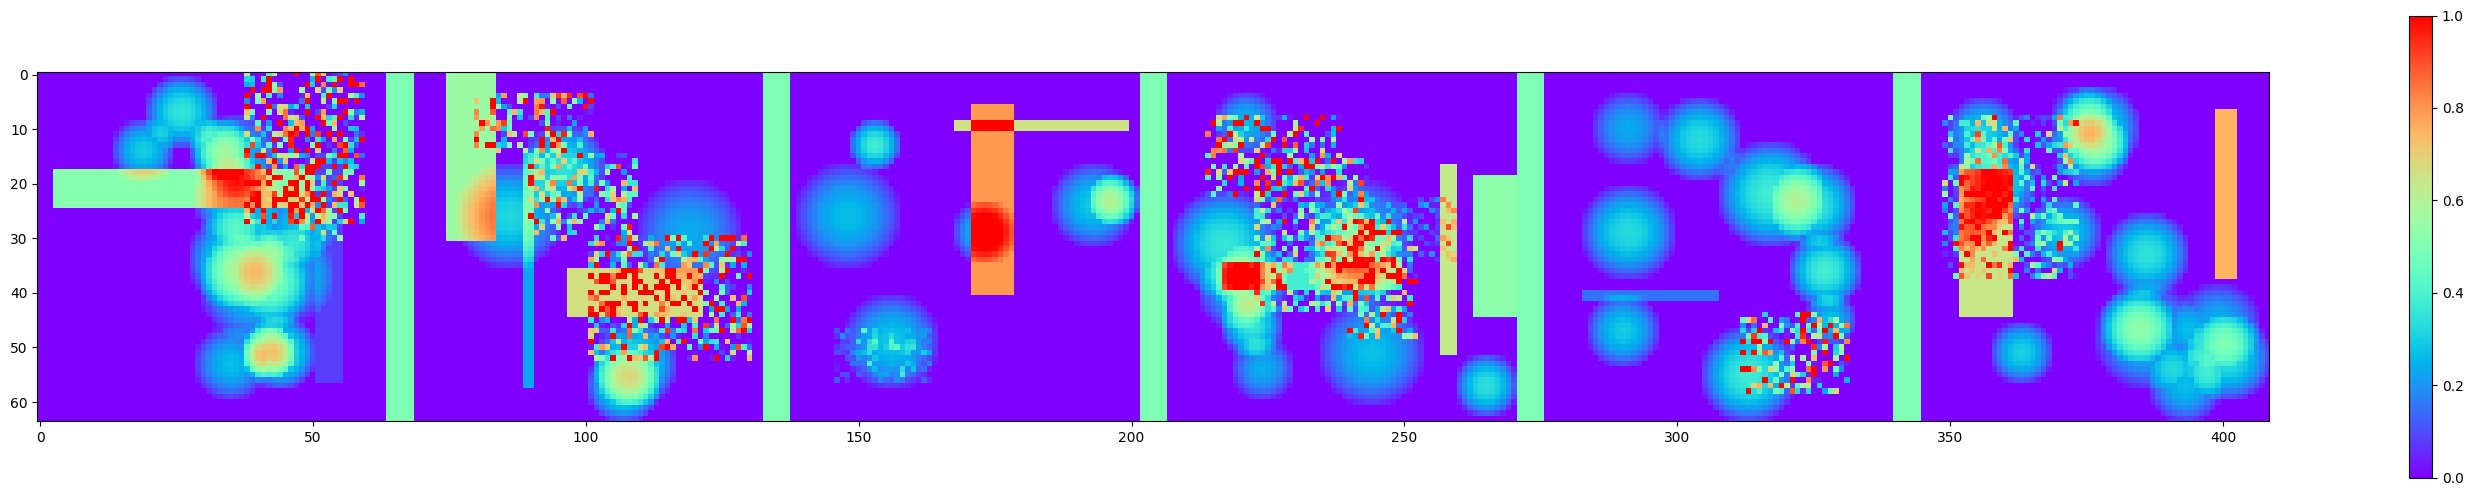

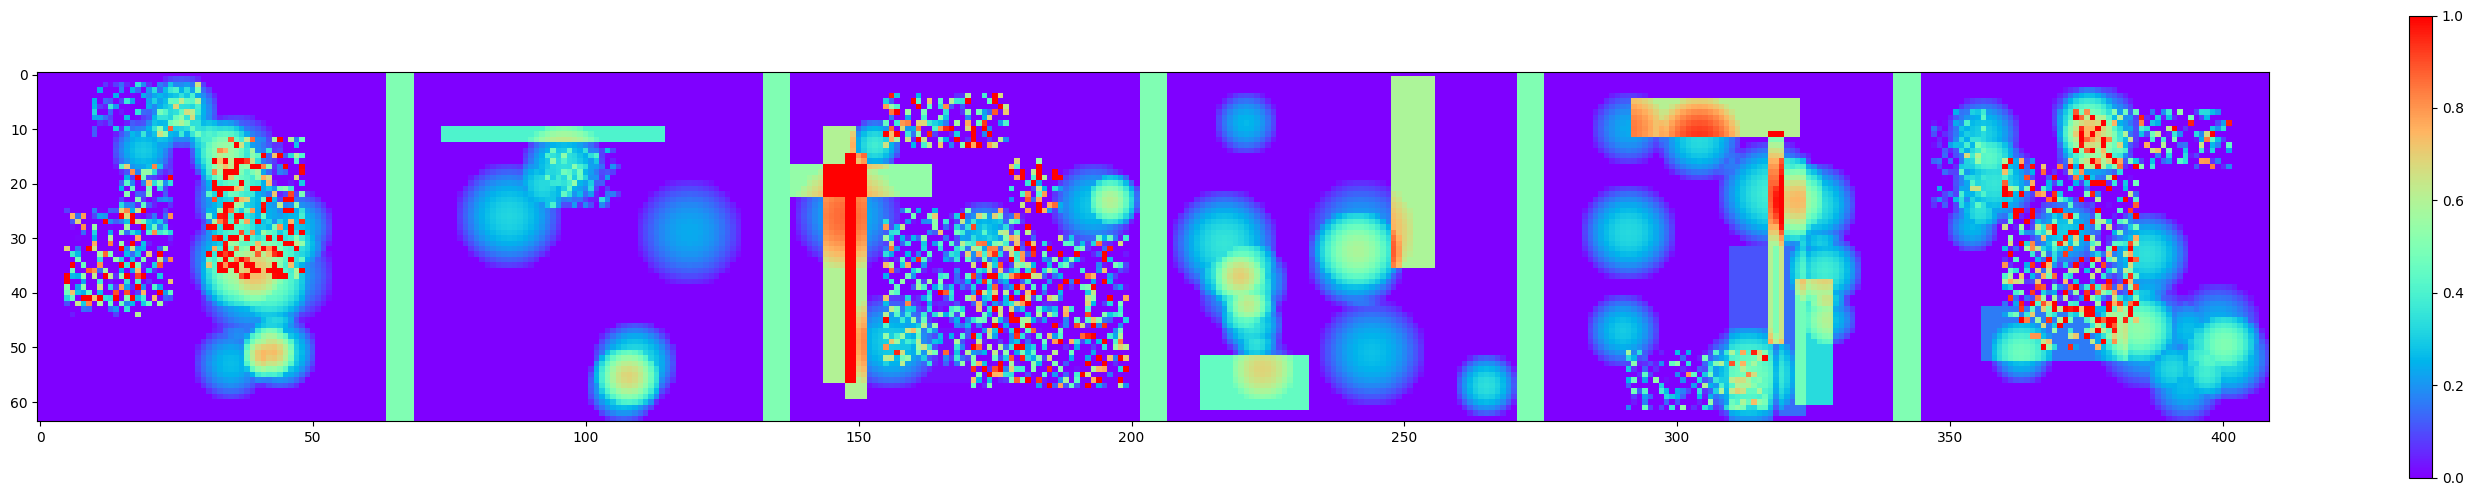

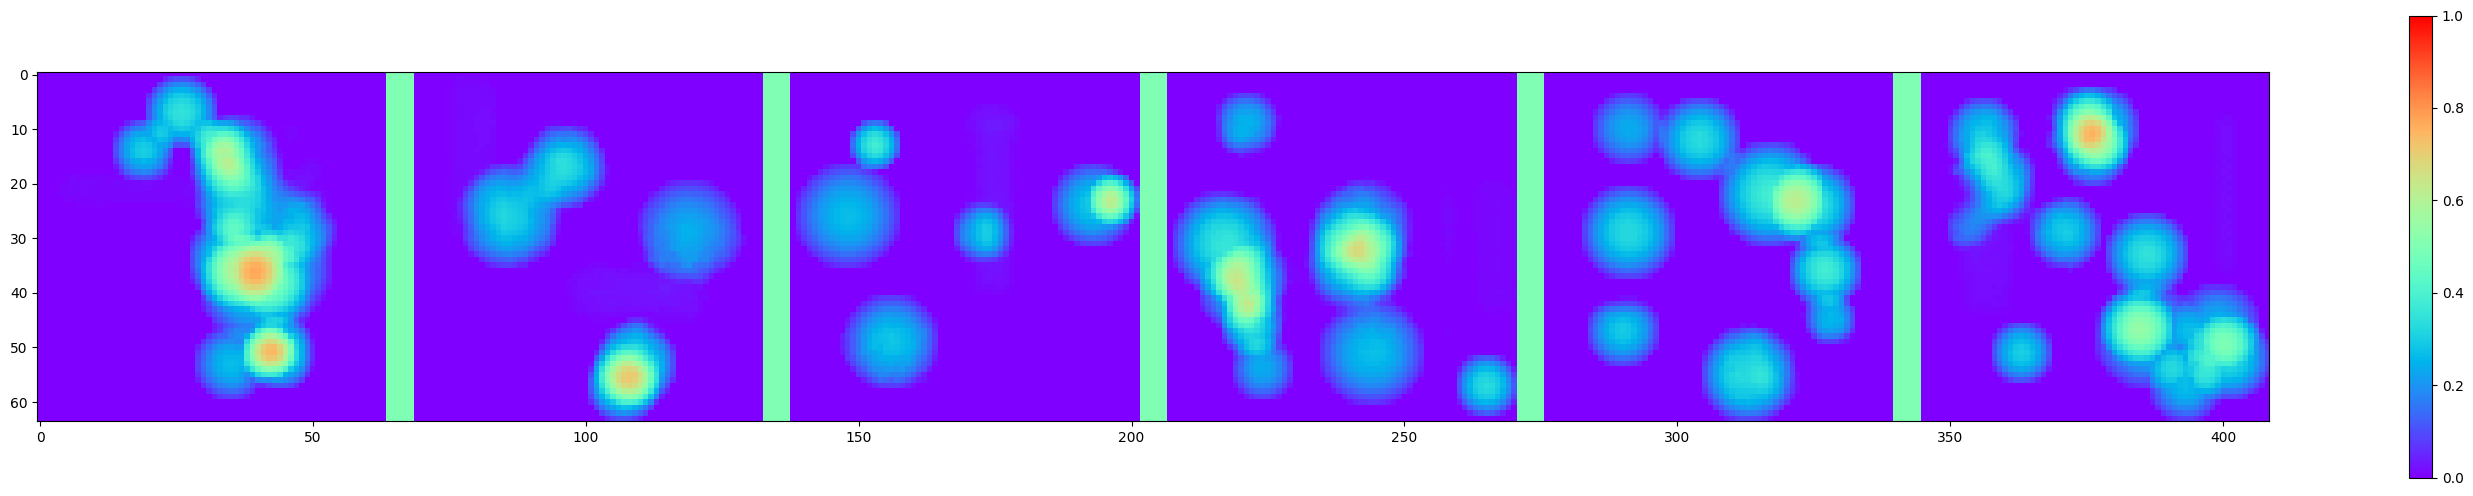

In [10]:
# viz:

fcn.eval()

input, target = gen_noise2noise(6)

output = fcn(input.cuda())


fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1)  # inputs
fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=0,max_scale=1)  # targets
fig3 = plt.figure(2, figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig2, k=0, min_scale=0,max_scale=1) # outputs


**Q2** Theoretical analysis:

The training procedure involves searching for the weights $\theta^*$ that satisfy:

\begin{equation}
\theta^* = \underset{\theta}{argmin} {\big \{} \mathbb{E}_{(X,Y)}[ \ \mathcal{L} (f_\theta(X), Y) \ ] {\big \}} \tag{1}
\end{equation}

Rewrite equation (1) to justify the approach taken for **Q1**.



We rewrite the expectation to be minimized in the case of a cost function equal to the Mean Absolute Error (MAE):

\begin{equation}
 \mathbb{E}_{(X,Y)}[ \ \mathcal{L} (f_\theta(X), Y) \ ] = \mathbb{E}_{X}[ \mathbb{E}_{Y | X}\ |f_\theta(X) - Y | \ ]
\end{equation}

To reach the minimum, the network must provide the conditional median of Y given X . In the case of a quadratic cost function, the network will suggest the conditional expectation. Unlike the median, this is biased, as clutter always contribute positively.


###Exercise 2: The "NES" scenario (Neural Egg Separation)

In another scenario, two sources of images can be sampled independently. The first provides noisy images containing the object of interest. Images from the second source contain only noise. Additionally, the corruption process, i.e., how the noise is combined with the clean image, is assumed to be known. This is a relatively common scenario. For instance, in the case of meteorological radar images, it is possible to extract images containing only noise during non-precipitation periods.

This scenario was defined by [Halperin et al (2018)](https://arxiv.org/pdf/1811.12739.pdf). These authors propose an iterative method to address it (Neural Egg Separation). In this exercise, we will rely on a fairly similar principle, still using our synthetic images.

The functions gen1_NES and gen2_NES allow sampling from the two sources. The corruption process is trivial: the noise (rectangles) is simply added to the clean image (cells).   



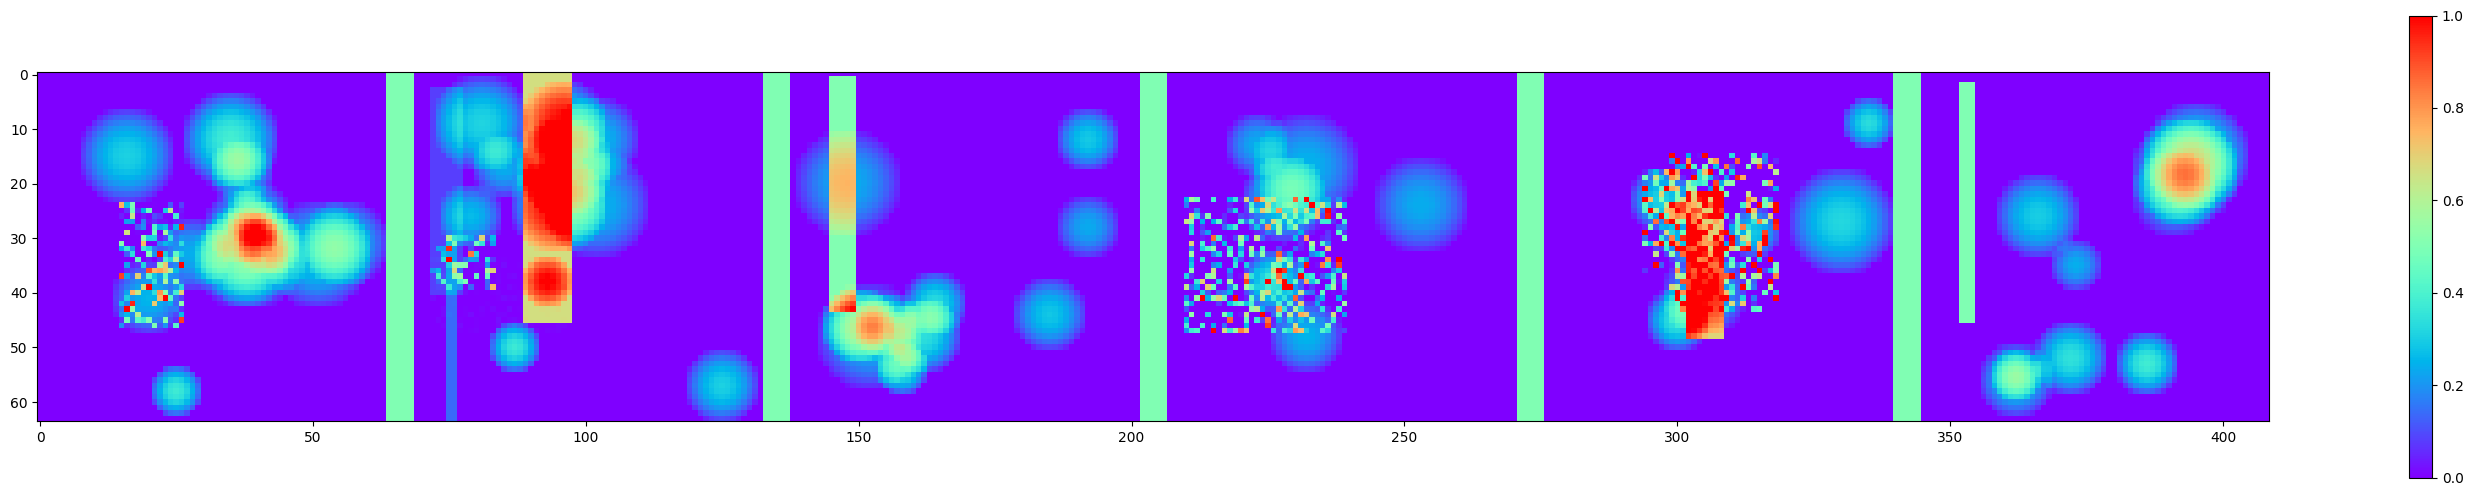

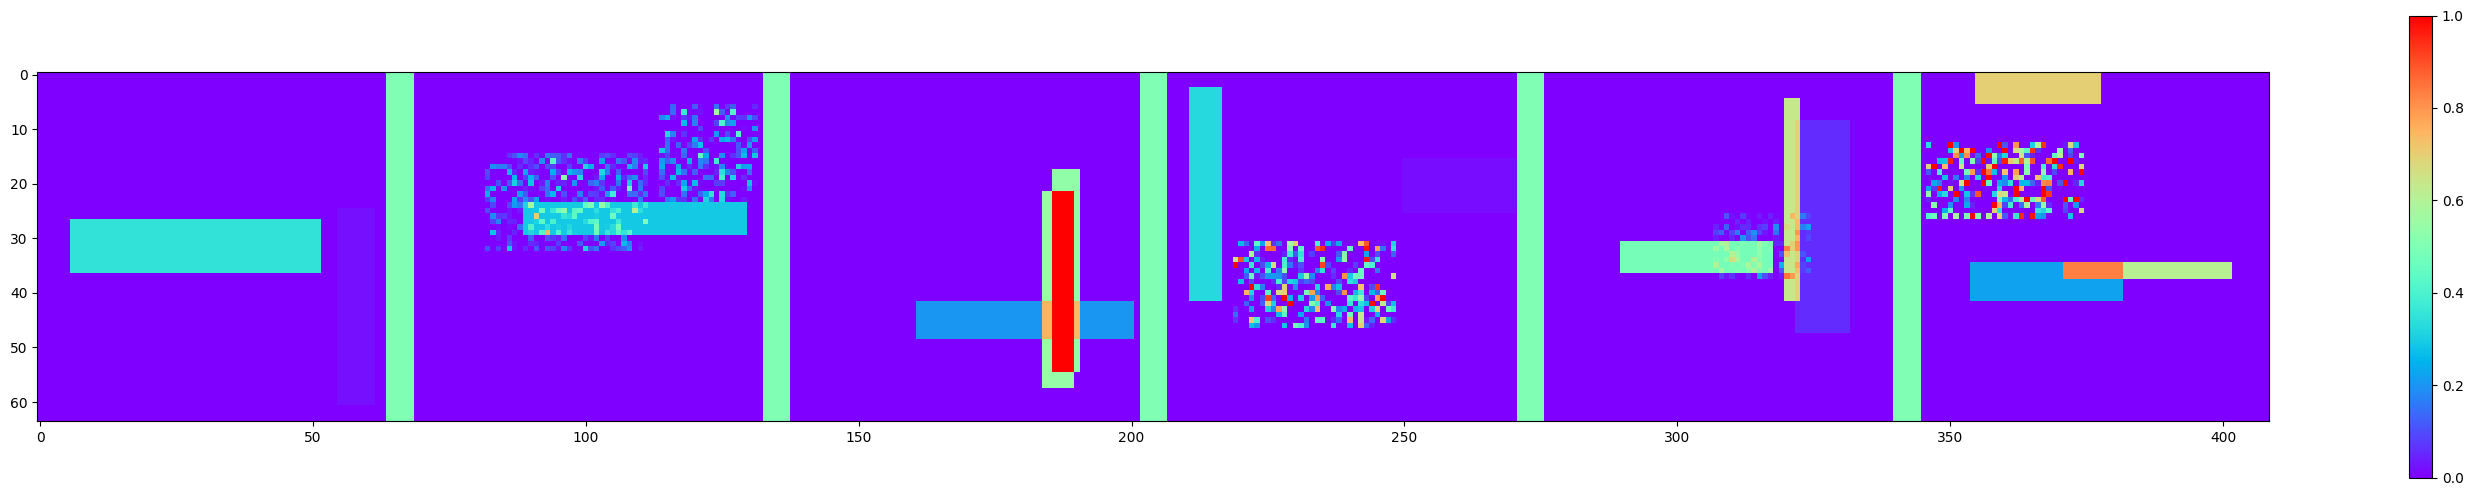

In [11]:
image1 = gen1_NES(6)
noise = gen2_NES(6)

# sample noisy pictures:
fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(image1, 6, fig, k=0, min_scale=0,max_scale=1)

# sample noise:
fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(noise, 6, fig2, k=0, min_scale=0,max_scale=1)

**Q1** Propose a learning strategy that leads to effective denoising.

**Q2** Discuss the limitations of the method and mention some avenues for improvement.

The idea is to add images containing noise and target the original image. By adding enough noise so that the additional artifacts dominate and by choosing the cost function appropriately, the network learns to denoise:

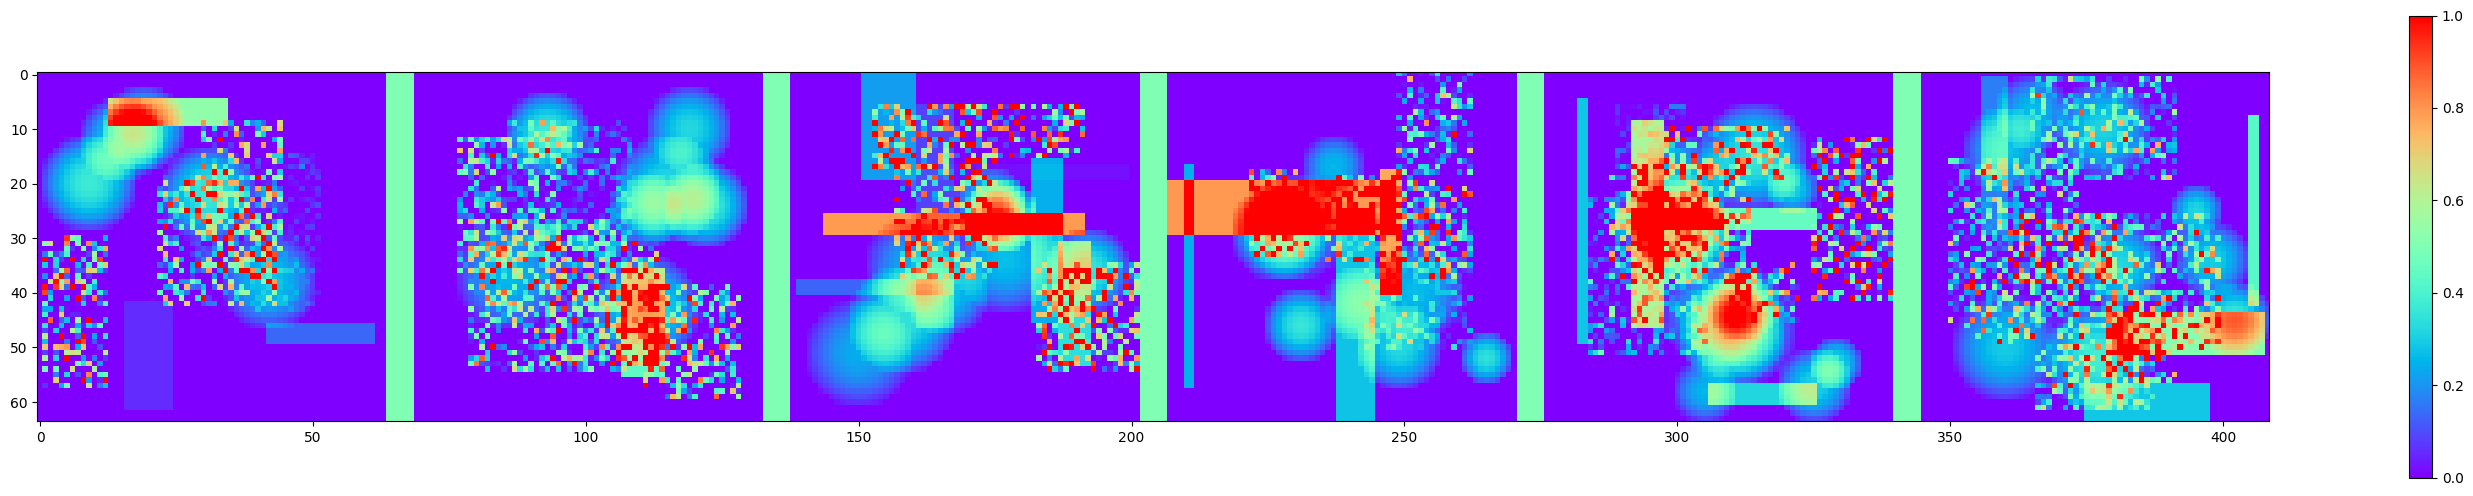

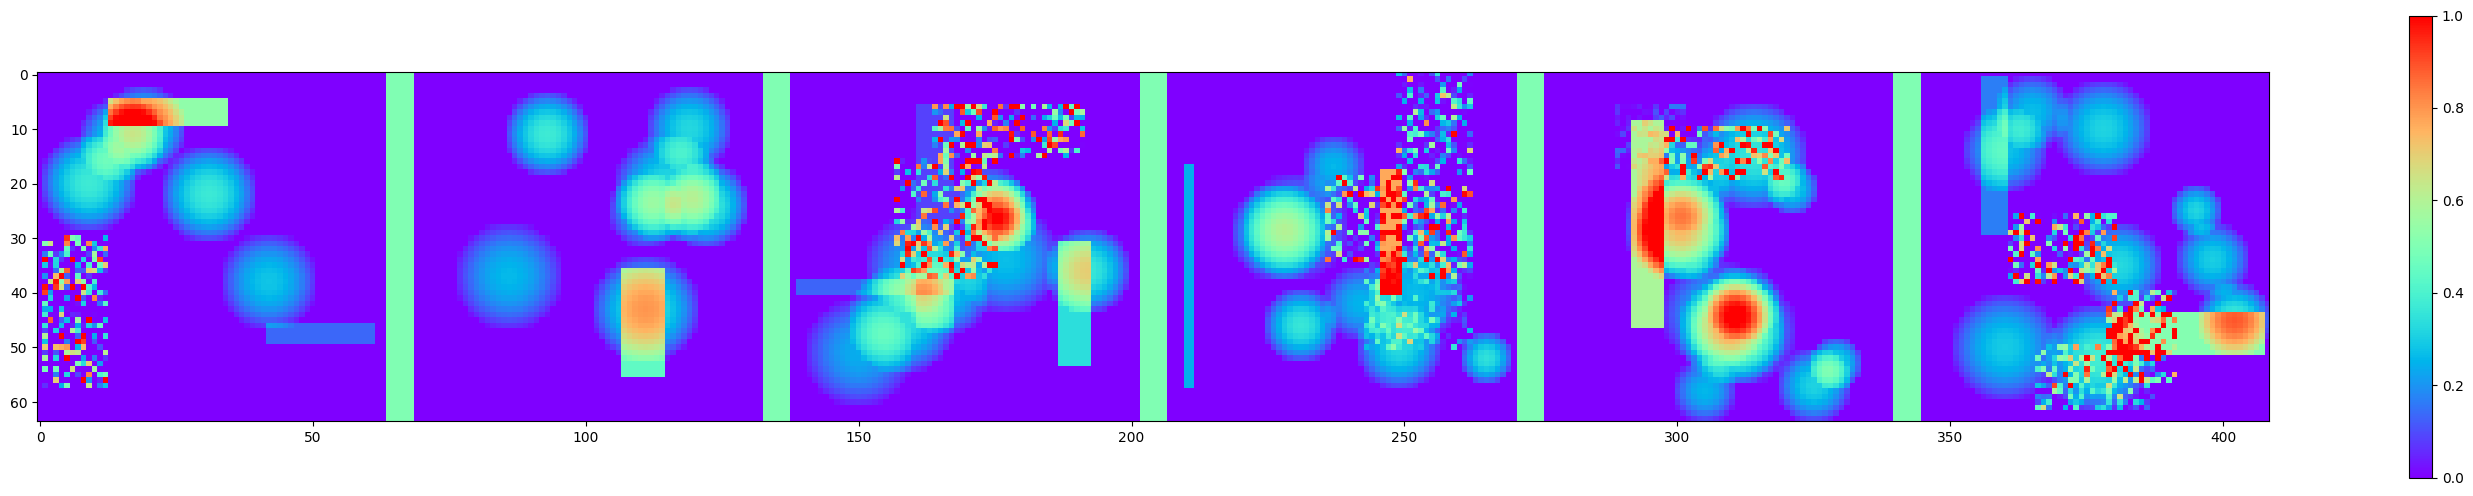

In [12]:
# Examples of (input, target) couples:

batchsize = 6
# Get image + noise and additional noises
image = gen1_NES(batchsize)
noise = gen2_NES(batchsize)
noise2 = gen2_NES(batchsize)

# Build input and targets
input = image + noise + noise2
target = image

# inputs
fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1)

# targets
fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=0,max_scale=1)

In [13]:
fcn = UNet(1,1,16).cuda()  #1 canal entrée, 1 canal de sortie, paramètre taille du réseau: 16

import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-3))

In [14]:
def criterion(output,target):
  return torch.mean(torch.abs(output-target))  # again, hope the conditionnal median
                                               # is a good estimator.

nepochs = 40
nbatches = 100
batchsize = 64

train_losses = []


for epoch in range(nepochs):


    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):    # nbatch = datasetsize/batchsize

        # generation
        image = gen1_NES(batchsize).cuda()
        noise = gen2_NES(batchsize).cuda()
        noise2 = gen2_NES(batchsize).cuda()

        # build the sum
        input = image + noise + noise2  #on ajoute deux images de bruit
        target = image

        # zeroing gradients, forward pass
        optimizer.zero_grad()
        output = fcn(input)

        # loss, gradients
        loss = criterion(output,target)
        loss.backward()

        # update weights
        optimizer.step()

        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)
    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

0.07874683
Epoch 1
epoch loss : 

0.06370344
Epoch 2
epoch loss : 

0.060061596
Epoch 3
epoch loss : 

0.056132134
Epoch 4
epoch loss : 

0.05600719
Epoch 5
epoch loss : 

0.054399606
Epoch 6
epoch loss : 

0.054417748
Epoch 7
epoch loss : 

0.053384174
Epoch 8
epoch loss : 

0.052927133
Epoch 9
epoch loss : 

0.052583013
Epoch 10
epoch loss : 

0.052429188
Epoch 11
epoch loss : 

0.051487613
Epoch 12
epoch loss : 

0.05137811
Epoch 13
epoch loss : 

0.051548492
Epoch 14
epoch loss : 

0.05165131
Epoch 15
epoch loss : 

0.051294144
Epoch 16
epoch loss : 

0.050947156
Epoch 17
epoch loss : 

0.050895974
Epoch 18
epoch loss : 

0.050137922
Epoch 19
epoch loss : 

0.051388588
Epoch 20
epoch loss : 

0.05038173
Epoch 21
epoch loss : 

0.050977234
Epoch 22
epoch loss : 

0.049950656
Epoch 23
epoch loss : 

0.049989432
Epoch 24
epoch loss : 

0.050181814
Epoch 25
epoch loss : 

0.048941188
Epoch 26
epoch loss : 

0.050550647
Epoch 27
epoch loss : 

0.049437955
Epoch 28

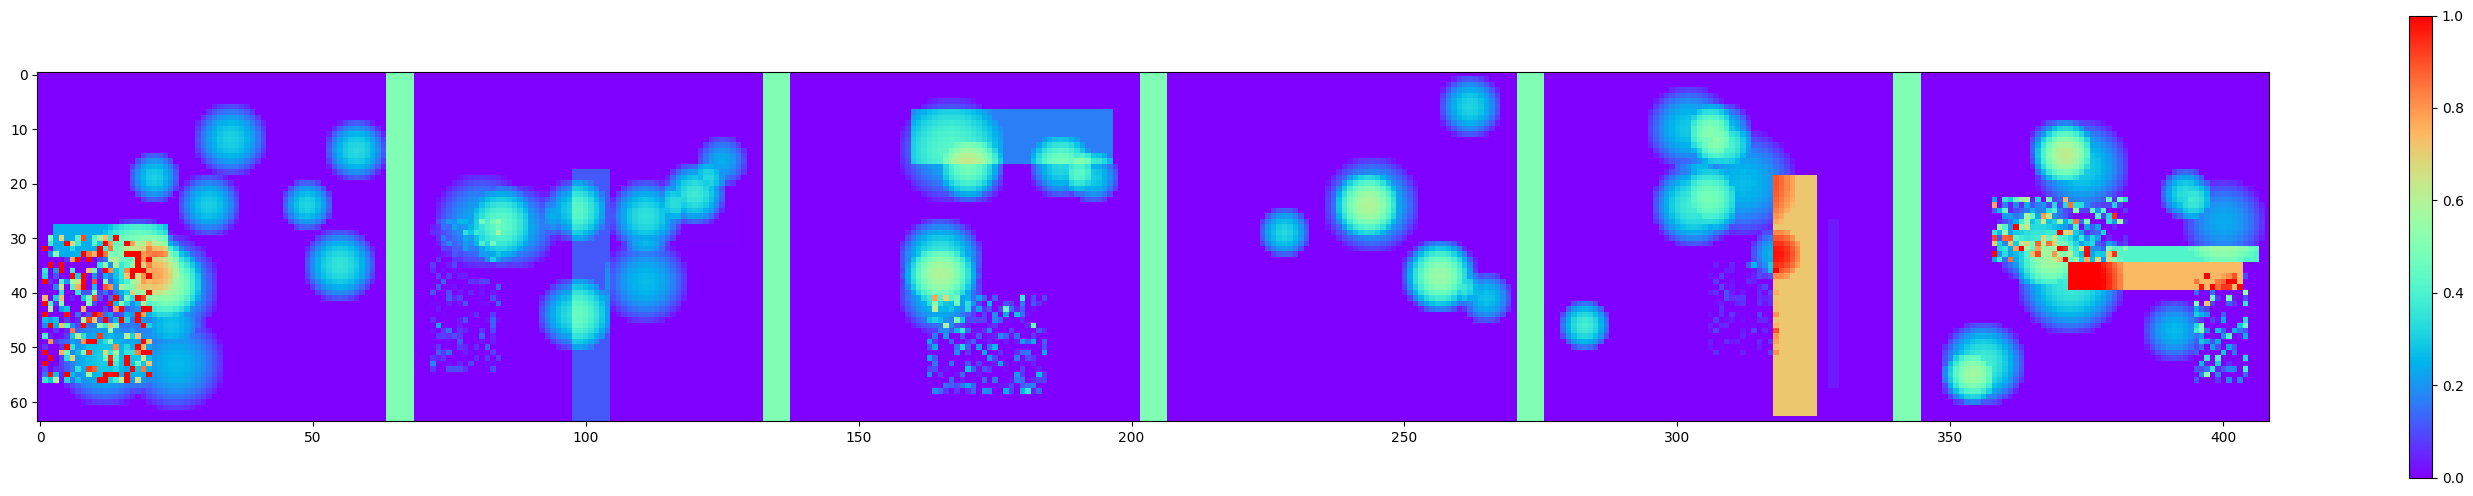

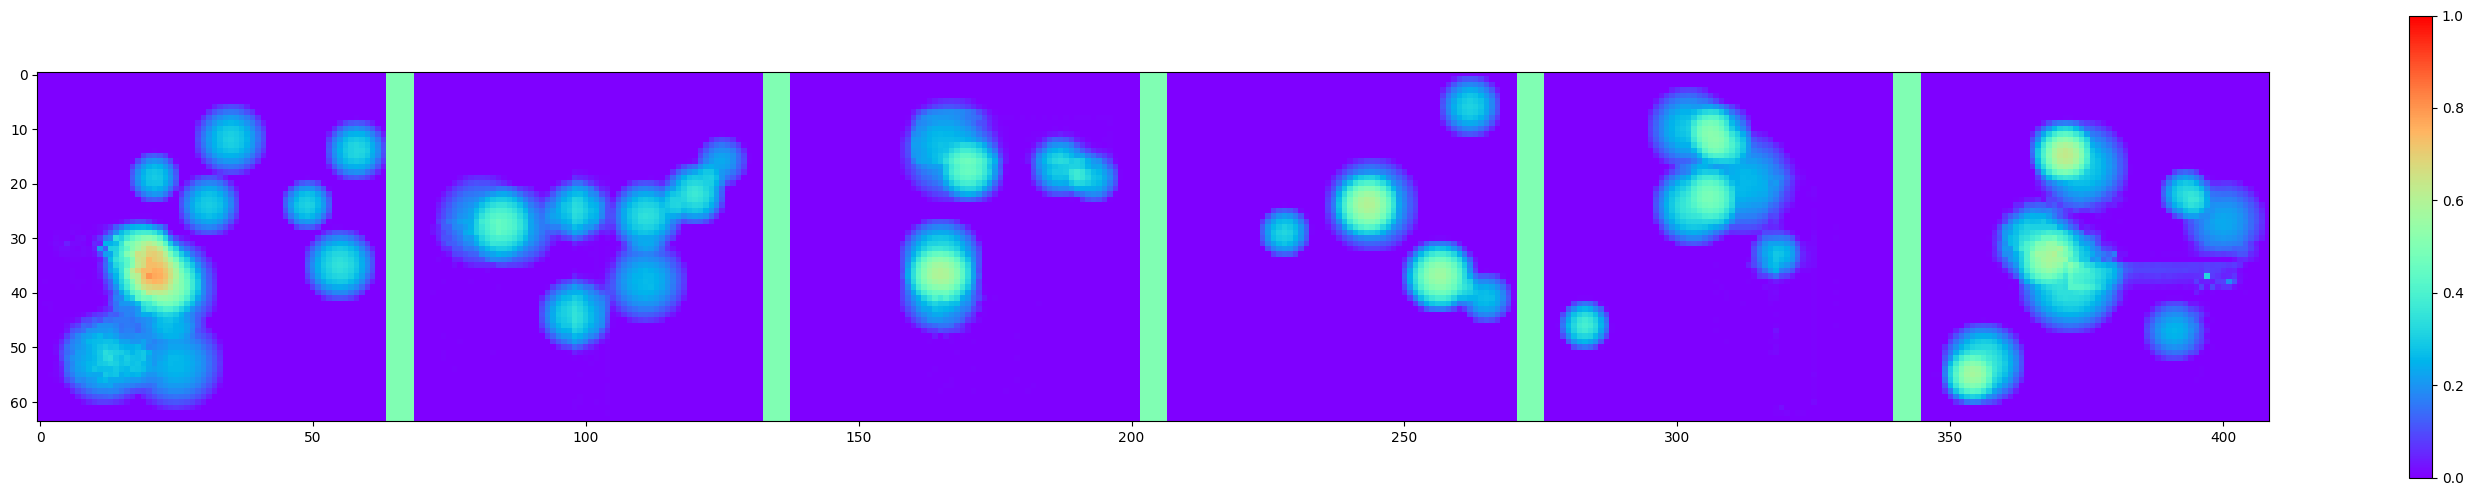

In [15]:
# viz:

fcn.eval()
input = gen1_NES(6)
output = fcn(input.cuda())



fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1)

fig3 = plt.figure(2, figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig2, k=0, min_scale=0,max_scale=1)

We can see that the reconstruction is not entirely perfect. However, these imperfections are explainable! When an overlap occurs, there is more than a fifty-fifty chance that at least one of the two patterns is present in the original image. To improve the processing, there are several methods. Exercise sheet number 2 provides an opportunity to explore one of them.